In [0]:
 ! pip install -q kaggle

In [0]:
from google.colab import files

In [0]:
! mkdir ~/.kaggle

In [0]:
! cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.16G/8.16G [03:07<00:00, 71.2MB/s]
100% 8.16G/8.16G [03:07<00:00, 46.6MB/s]


In [10]:
! mkdir train

mkdir: cannot create directory ‘train’: File exists


In [0]:
! unzip flickr-image-dataset.zip -d train

In [0]:
!rm -r "/content/train/flickr30k_images/flickr30k_images/flickr30k_images"

In [24]:
!ls -l /content/train/flickr30k_images/flickr30k_images/ | grep ^- | wc -l

31784


In [0]:
import pandas as pd
df = pd.read_csv("/content/train/flickr30k_images/results.csv",sep = '|')

In [4]:
df.head()

image_name  ...                                            comment
0  1000092795.jpg  ...   Two young guys with shaggy hair look at their...
1  1000092795.jpg  ...   Two young , White males are outside near many...
2  1000092795.jpg  ...   Two men in green shirts are standing in a yard .
3  1000092795.jpg  ...       A man in a blue shirt standing in a garden .
4  1000092795.jpg  ...            Two friends enjoy time spent together .

[5 rows x 3 columns]

In [0]:
import re
def preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r"/'m"," am",text)
    text = re.sub(r"/'s"," is",text)
    text = re.sub(r"/'ll"," will",text)
    text = re.sub(r"/'ve"," have",text)
    text = re.sub(r"/'re"," are",text)
    text = re.sub(r"won't","will not",text)
    text = re.sub(r"can't","can not",text)
    text = re.sub(r"[-{}\|$()?.,]","",text)
    text = re.sub(r'[^a-z]+',' ',text)
    text = text.replace("  "," ")
    text = text.lstrip(" ")
    text = text.rstrip(" ")
    text = 'startseq ' + text + ' endseq'
    return text

In [6]:
df[" comment"].head()

0     Two young guys with shaggy hair look at their...
1     Two young , White males are outside near many...
2     Two men in green shirts are standing in a yard .
3         A man in a blue shirt standing in a garden .
4              Two friends enjoy time spent together .
Name:  comment, dtype: object

In [0]:
df[" comment"]=df[" comment"].apply(preprocessing)

In [8]:
df.shape[0]

158915

In [0]:
ids_for_testing_purpose = list(df.groupby("image_name").first()[-100:].index)

In [0]:
test_df = df[df.image_name.isin(ids_for_testing_purpose)]

df = df[~df.image_name.isin(ids_for_testing_purpose)]


In [11]:
df.shape[0]

158415

In [0]:
lines = []
for i in range(df.shape[0]):
    lines.append(df[" comment"][i])

In [0]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df = 15)

vectorized_corpus = cv.fit_transform(lines)


In [126]:
len(cv.vocabulary_)

4336

In [0]:
imgs = df.groupby(by = "image_name").first().reset_index()["image_name"]

In [16]:
imgs[2]

'1000268201.jpg'

In [17]:
for i in df[df["image_name"] == '1000092795.jpg'][" comment"]:
    print(i)

startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq
startseq two young white males are outside near many bushes endseq
startseq two men in green shirts are standing in a yard endseq
startseq a man in a blue shirt standing in a garden endseq
startseq two friends enjoy time spent together endseq


In [18]:
img_sent_dic = {}
for i in range(imgs.shape[0]):
    if(i%1000==0):
        print(i)
    sent_list = []
    for j in df[df["image_name"] == imgs[i]][" comment"]:
        sent_list.append(j)
    img_sent_dic[imgs[i]] = sent_list

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000


In [0]:
id_word = dict([(val,key) for (key,val) in cv.vocabulary_.items()])

In [128]:
len(id_word)

4336

In [129]:
id_word[4336]

KeyError: ignored

In [0]:
cv.vocabulary_['?'] = 4336

In [0]:
id_word = dict([(val,key) for (key,val) in cv.vocabulary_.items()])

In [132]:
id_word[4336]

'?'

In [0]:
import cv2
from keras.preprocessing import image


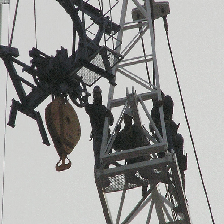

In [25]:
img = image.load_img("/content/train/flickr30k_images/flickr30k_images/10002456.jpg",target_size = (224,224,3))
img

In [26]:
img_sent_dic["10002456.jpg"]

['startseq several men in hard hats are operating a giant pulley system endseq',
 'startseq workers look down from up above on a piece of equipment endseq',
 'startseq two men working on a machine wearing hard hats endseq',
 'startseq four men on top of a tall structure endseq',
 'startseq three men on a large rig endseq']

In [1]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model
import numpy as np

Using TensorFlow backend.


In [57]:
pip install -U keras

     |████████████████████████████████| 378kB 1.4MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [2]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))

102858752/102853048 [==============================] - 9s 0us/step


In [0]:
new_model = Model(model.input,model.layers[-2].output)

In [28]:
new_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
def preprocess_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [30]:
img = preprocess_img("/content/train/flickr30k_images/flickr30k_images/10002456.jpg")
img.shape

(1, 224, 224, 3)

In [0]:
def encode_image(img_path):
    img = preprocess_img(img_path)
    feature_vector = new_model.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [33]:
encode_image("/content/train/flickr30k_images/flickr30k_images/10002456.jpg")


array([0.36159626, 0.11664453, 0.5121396 , ..., 1.7043732 , 1.2657216 ,
       0.        ], dtype=float32)

In [34]:
encode_dict = {}
idx = 0
for img in list(df["image_name"].value_counts().index):
    encode_dict[img] = encode_image("/content/train/flickr30k_images/flickr30k_images/"+img)
    if (idx%100==0):
         print(idx)
    idx+=1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [36]:
test_encode_dict = {}
idx = 0
for img in list(test_df["image_name"].value_counts().index):
    test_encode_dict[img] = encode_image("/content/train/flickr30k_images/flickr30k_images/"+img)
    if (idx%100==0):
         print(idx)
    idx+=1

0


In [0]:
# import pickle
# with open('test_encode_dict.pickle', 'wb') as handle:
#     pickle.dump(test_encode_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('encode_dict.pickle', 'wb') as handle:
#     pickle.dump(encode_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('term_dict.pickle', 'wb') as handle:
    pickle.dump(cv.vocabulary_, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('img_sent_dic.pickle', 'wb') as handle:
#     pickle.dump(img_sent_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('test_data.pickle', 'wb') as handle:
#     pickle.dump(test_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
from keras.preprocessing import sequence
from keras.utils import to_categorical
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = sequence.pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorcial([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [133]:
cv.vocabulary_['startseq']

3590

In [40]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip

--2020-04-02 06:53:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-02 06:53:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-02 06:53:08--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
glove_embedding = {}
with open("glove.6B.50d.txt",'r') as f:
    for i in f:
        ax = i.split()
        glove_embedding[ax[0]]=np.array(ax[1:],dtype='float')
embedding_dim = 50

In [0]:
vocab_size = len(cv.vocabulary_)
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in cv.vocabulary_.items():
        embedding_vector = glove_embedding.get(word)
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

In [0]:
embedding_matrix = get_embedding_matrix()

In [137]:
embedding_matrix[3530]

array([ 0.40008  , -0.042758 ,  0.32291  ,  0.16325  , -0.34277  ,
        1.2105   ,  0.38166  ,  0.18645  , -0.0067758, -0.35025  ,
       -0.62913  , -0.49952  , -0.70291  ,  0.20961  , -0.6855   ,
        0.11617  , -0.13909  , -0.34102  ,  0.40018  , -0.048581 ,
        0.1346   , -0.40508  ,  0.50408  ,  0.7567   ,  0.020022 ,
       -0.18649  ,  0.16837  ,  0.5755   ,  0.48299  ,  0.051196 ,
        1.3958   ,  0.063021 ,  0.41097  ,  0.37281  , -0.28561  ,
       -0.65235  , -0.99214  , -0.52838  , -0.12337  , -0.027228 ,
       -0.55183  , -0.49494  , -0.28043  ,  0.35577  , -0.97129  ,
        0.14823  ,  0.72248  , -0.22742  , -0.13275  , -0.6814   ])

In [138]:
from keras.layers import *
from keras.layers.core import Dense, Reshape
max_len = 35
input1 = Input(shape=(2048,))
fe1 = Dropout(0.3)(input1)
fe2 = Dense(256,activation = 'relu')(fe1)

input2 = Input(shape= (max_len,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero = True)(input2)
se2 = Dropout(0.3)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2,se3])
decoder2 = Dense(256,activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs = [input1,input2], outputs = outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 35, 50)       216850      input_9[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 2048)         0           input_8[0][0]                    
____________________________________________________________________________________________

In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [0]:
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam')

In [0]:
epochs = 7
batch_size = 16
max_len = 35
steps = len(img_sent_dic)//8
def train():
    for i in range(epochs):
        generator = data_generator(img_sent_dic,encode_dict,cv.vocabulary_,max_len,batch_size)
        model.fit_generator(generator,epochs = 1,steps_per_epoch = steps ,verbose = 1)
        model.save('model_'+str(i)+'.h5')

In [142]:
from keras.preprocessing import sequence
from keras.utils import to_categorical
train()

ERROR! Session/line number was not unique in database. History logging moved to new session 61
Epoch 1/1
3960/3960 [==============================] - 451s 114ms/step - loss: 4.0776
Epoch 1/1
3960/3960 [==============================] - 452s 114ms/step - loss: 3.5343
Epoch 1/1
3960/3960 [==============================] - 454s 115ms/step - loss: 3.3914
Epoch 1/1
3960/3960 [==============================] - 451s 114ms/step - loss: 3.3160
Epoch 1/1
3960/3960 [==============================] - 448s 113ms/step - loss: 3.2667
Epoch 1/1
3960/3960 [==============================] - 452s 114ms/step - loss: 3.2316
Epoch 1/1
3960/3960 [==============================] - 452s 114ms/step - loss: 3.2056


In [0]:
from keras.models import load_model
model = load_model("model_6.h5")

In [0]:
def predict_caption(photo):
    in_text = "startseq"
    for i in range(max_len):
        sequen = [cv.vocabulary_[w] for w in in_text.split() if w in cv.vocabulary_]
        sequen = sequence.pad_sequences([sequen],maxlen=max_len,value=0,padding = 'post')
        
        ypred = model.predict([photo,sequen])
        ypred = ypred.argmax()
        word = id_word[ypred]
        in_text += ' '+word
        if word=='endseq':
            break
            
    final_caption = in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

In [144]:
predict_caption(test_encode_dict["96399948.jpg"].reshape((1,2048)))

'man in red shirt is playing with toy'

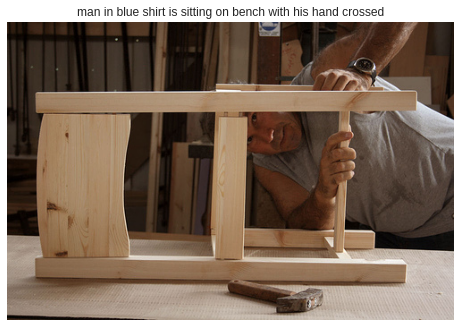

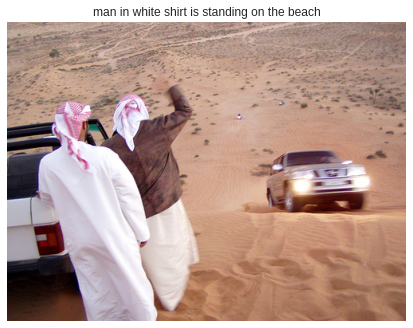

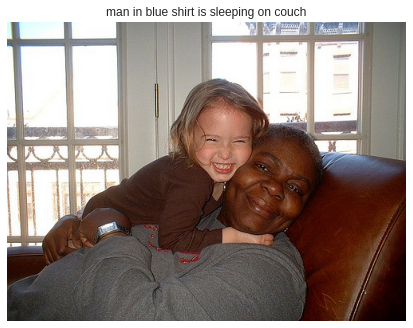

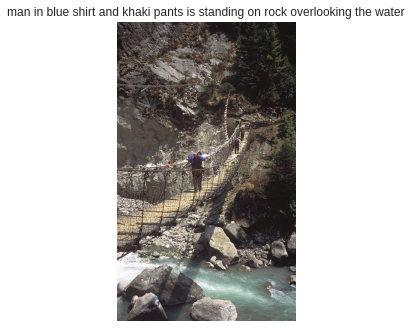

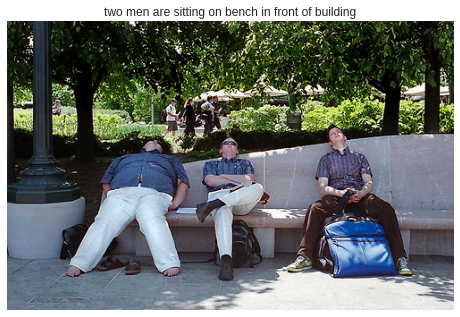

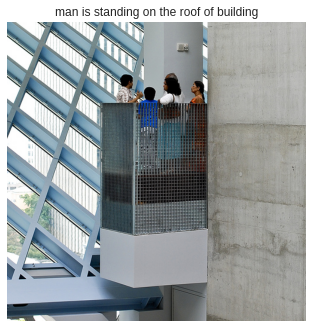

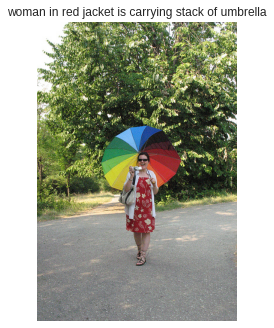

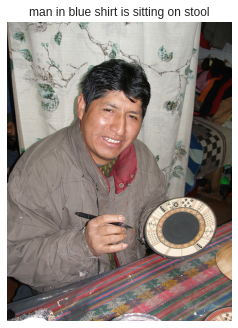

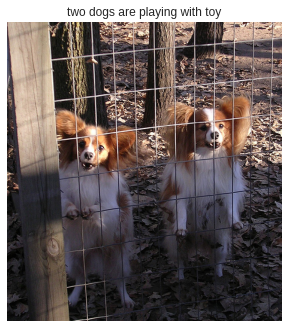

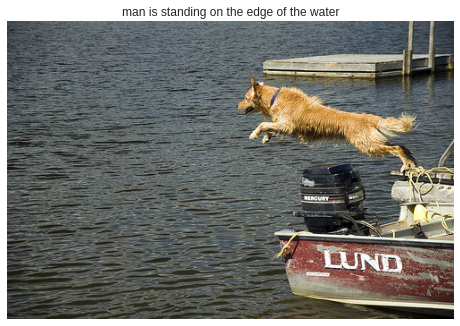

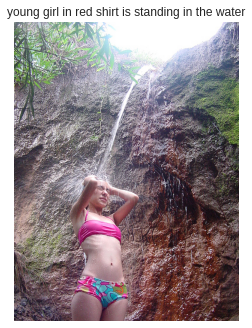

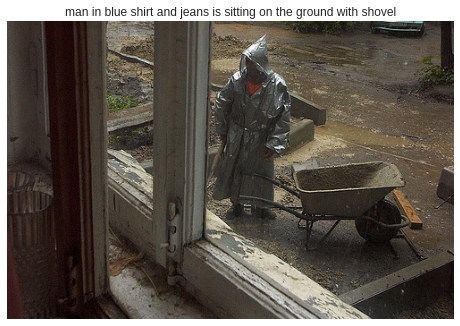

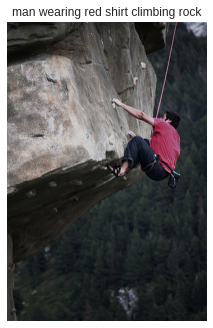

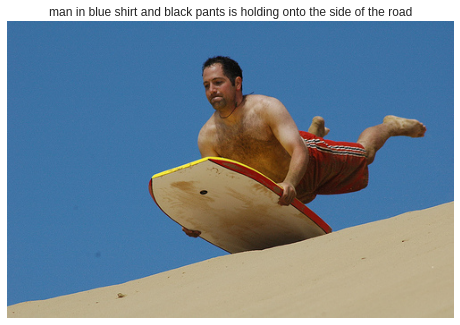

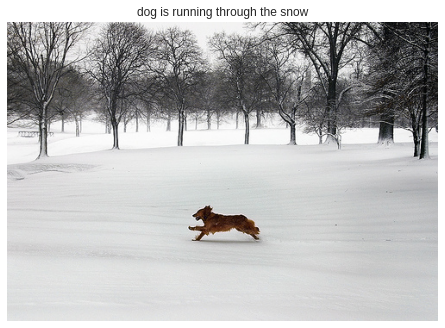

In [154]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(20,90)
    all_img_names = list(test_encode_dict.keys())
    img_name = all_img_names[idx]
    photo_2048 = test_encode_dict[img_name].reshape((1,2048))
    
    i = plt.imread("/content/train/flickr30k_images/flickr30k_images/"+img_name)
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()